<h3><center>Detecting Fake News</center></h3>   

    
<center>Sam Loyd</center>
<center>July 2021</center> 

In [116]:
# Required Modules
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import *
from imblearn.combine import SMOTETomek
from collections import Counter
from pycaret.classification import *
from sklearn import metrics
from sklearn.impute import KNNImputer
import nltk
from nltk.stem import PorterStemmer
import pickle
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import accuracy_score
import neattext as nt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok

In [2]:
# Pull in data for stroke data 
true_df = pd.read_csv("data\\True.csv")
fake_df = pd.read_csv("data\\Fake.csv")

In [3]:
# Set status
true_df['fake']=0
fake_df['fake']=1

In [4]:
# Setup frame
frames = [true_df, fake_df]

In [5]:
# Join them
fake_news_df = pd.concat(frames)

In [6]:
# First look
fake_news_df

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [7]:
# Reset the index
fake_news_df = fake_news_df.reset_index(drop=True)

In [8]:
# Remove entries with bogus dates
tmp_df = fake_news_df[fake_news_df.date.apply(lambda x: len(str(x))<=30)] 

In [9]:
# Copy over
fake_news_df = tmp_df

In [10]:
# Reset the index
fake_news_df = fake_news_df.reset_index(drop='True')

In [11]:
# convert the 'Date' column to datetime format
fake_news_df['date']= pd.to_datetime(fake_news_df['date'])

In [12]:
# Apply profile and create html report
# Commented out for performance
# prof = ProfileReport(fake_news_df,title="Pandas Profiling Report - Fake News Data", explorative=True)
# prof.to_file(output_file='fakenews-pandas-profile-report.html')

# Please see stroke-pandas-profile-report.html for a full analysis 

In [13]:
# Remove 196 duplicates
fake_news_df.drop_duplicates(keep='first', inplace=True)

In [14]:
# Function to clean up text 
# Replaces all of these and then some with level = deep ...

#neattxtpr = nt.remove_puncts(neattxtpr)
#neattxtpr = nt.remove_stopwords(neattxtpr)
#neattxtpr = nt.remove_html_tags(neattxtpr)
#neattxtpr = nt.remove_special_characters(neattxtpr)
#neattxtpr = nt.remove_emojis(neattxtpr)
#neattxtpr = nt.fix_contractions(neattxtpr)

def preproc(neattxt):
    neattxtpr = nt.normalize(neattxt,level='deep')
    neattxtpr = nt.remove_stopwords(neattxtpr)

    return neattxtpr

In [15]:
# preprocess title
fake_news_df['title_cl'] = fake_news_df['title'].apply(preproc)

In [16]:
# preprocess text
fake_news_df['text_cl'] = fake_news_df['text'].apply(preproc)

In [17]:
# Verify types
fake_news_df.dtypes

title               object
text                object
subject             object
date        datetime64[ns]
fake                 int64
title_cl            object
text_cl             object
dtype: object

In [18]:
# Drop subject as it must be future data to be almost 100% correlated to fake
clean_fake_news_df = fake_news_df.drop(['subject','title','text'], axis=1)

In [19]:
# Get year, month, day, julia and day of week

In [20]:
clean_fake_news_df['year'] = pd.DatetimeIndex(clean_fake_news_df['date']).year

In [21]:
clean_fake_news_df['month'] = pd.DatetimeIndex(clean_fake_news_df['date']).month

In [22]:
clean_fake_news_df['day'] = pd.DatetimeIndex(clean_fake_news_df['date']).day

In [23]:
clean_fake_news_df['julia'] = pd.DatetimeIndex(clean_fake_news_df['date']).to_julian_date()

In [24]:
clean_fake_news_df['day'] = pd.DatetimeIndex(clean_fake_news_df['date']).day

In [25]:
clean_fake_news_df['dayofweek'] = clean_fake_news_df['date'].dt.day_name()

In [26]:
# Check stats
clean_fake_news_df.describe()

,fake,year,month,day,julia
count,44679.000000,44679.000000,44679.000000,44679.000000,4.467900e+04
mean,0.525258,2016.521565,7.208241,15.560823,2.457782e+06
std,0.499367,0.601693,3.516935,8.677324,2.530573e+02
min,0.000000,2015.000000,1.000000,1.000000,2.457112e+06
25%,0.000000,2016.000000,4.000000,8.000000,2.457578e+06
50%,1.000000,2017.000000,8.000000,15.000000,2.457816e+06
75%,1.000000,2017.000000,10.000000,23.000000,2.458020e+06
max,1.000000,2018.000000,12.000000,31.000000,2.458168e+06


In [27]:
# Tokenize
clean_fake_news_df['title_cl'] = clean_fake_news_df['title_cl'].apply(nltk.word_tokenize)

clean_fake_news_df['text_cl'] = clean_fake_news_df['text_cl'].apply(nltk.word_tokenize)

In [28]:
# Stemmer
stemmer = PorterStemmer()

In [29]:
# Apply stemming
clean_fake_news_df['title_cl'] = clean_fake_news_df['title_cl'].apply(lambda x: [stemmer.stem(y) for y in x])
clean_fake_news_df['text_cl'] = clean_fake_news_df['text_cl'].apply(lambda x: [stemmer.stem(y) for y in x])

In [30]:
# Untokenize
detokenizer = Detok()

In [31]:
# Detokenize for vectorizing below
clean_fake_news_df['title_cl'] = clean_fake_news_df['title_cl'].apply(detokenizer.detokenize)

clean_fake_news_df['text_cl'] = clean_fake_news_df['text_cl'].apply(detokenizer.detokenize)

In [32]:
# Use one-hot encoding on days of week
one_hot = pd.get_dummies(clean_fake_news_df.dayofweek)

In [33]:
# Drop original
clean_fake_news_df = clean_fake_news_df.drop('dayofweek',axis = 1)
clean_fake_news_df = clean_fake_news_df.join(one_hot)

In [34]:
# final clean up before passing ...
clean_fake_news_df.reset_index(drop=True, inplace=True)

In [35]:
# Apply profile and create html report
# Commented out for performance
# prof = ProfileReport(clean_fake_news_df,title="Pandas Profiling Report - Cleaned Fake News Data", explorative=True)
# prof.to_file(output_file='clean_fakenews-pandas-profile-report.html')

# Please see stroke-pandas-profile-report.html for a full analysis 

In [36]:
# Normalize with minmax_scale
clean_fake_news_df[['year','month','day','julia']] = minmax_scale(clean_fake_news_df[['year','month','day','julia']])

In [37]:
# Split based on time - Hold out most recent data for train/validation which I will randomly split
train = clean_fake_news_df[clean_fake_news_df['date'] < '2017-09-01']

In [38]:
# Ditto
val = clean_fake_news_df[clean_fake_news_df['date'] >= '2017-09-01']

In [39]:
# Quick count
train.date.count()

30718

In [40]:
# Ditto
val.date.count()

13961

In [41]:
# Setup vectorizer for title
vectorizer = TfidfVectorizer(max_features=1000)
title_train = pd.DataFrame(vectorizer.fit_transform(train.title_cl).todense(),columns=vectorizer.get_feature_names())
title_val = pd.DataFrame(vectorizer.transform(val.title_cl).todense(),columns=vectorizer.get_feature_names())

In [42]:
# Setup vectorizer for title
vectorizer = TfidfVectorizer(max_features=1000)
text_train = pd.DataFrame(vectorizer.fit_transform(train.text_cl).todense(),columns=vectorizer.get_feature_names())
text_val = pd.DataFrame(vectorizer.transform(val.text_cl).todense(),columns=vectorizer.get_feature_names())

In [43]:
# Retitle or it confuses vectorizer 
text_train = text_train.add_suffix('_in_text')
text_val = text_val.add_suffix('_in_text')
title_train = title_train.add_suffix('_in_title')
title_val = title_val.add_suffix('_in_title')

In [44]:
# Merge into one
tdif_train = pd.concat([title_train,text_train],axis=1)
tdif_val = pd.concat([title_val,text_val],axis=1)

In [45]:
# Merge with original
train = pd.concat([train.reset_index(drop=True),tdif_train.reset_index(drop=True)],axis=1)
val = pd.concat([val.reset_index(drop=True),tdif_val.reset_index(drop=True)],axis=1)

In [46]:
# Drop columns 
train=train.drop(['title_cl','text_cl'], axis=1).reset_index(drop=True)
val=val.drop(['title_cl','text_cl'], axis=1).reset_index(drop=True)

In [47]:
# Quick look before modeling - Pycaret handles the test split
train

,date,fake,year,month,day,julia,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,abort_in_title,absolut_in_title,abus_in_title,accept_in_title,access_in_title,accident_in_title,account_in_title,accus_in_title,act_in_title,action_in_title,activist_in_title,actor_in_title,actual_in_title,ad_in_title,address_in_title,administr_in_title,admit_in_title,advis_in_title,advisor_in_title,agenc_in_title,agenda_in_title,agent_in_title,agre_in_title,ahead_in_title,aid_in_title,aim_in_title,air_in_title,al_in_title,alien_in_title,alleg_in_title,alli_in_title,allow_in_title,ambassador_in_title,amend_in_title,america_in_title,american_in_title,amid_in_title,anchor_in_title,angri_in_title,announc_in_title,answer_in_title,antifa_in_title,antitrump_in_title,apart_in_title,apolog_in_title,appeal_in_title,appear_in_title,appoint_in_title,approv_in_title,arm_in_title,armi_in_title,arrest_in_title,ask_in_title,assassin_in_title,assault_in_title,attack_in_title,attempt_in_title,attend_in_title,attorney_in_title,audienc_in_title,audio_in_title,author_in_title,avoid_in_title,away_in_title,awesom_in_title,babi_in_title,back_in_title,bad_in_title,baltimor_in_title,ban_in_title,bank_in_title,bannon_in_title,bar_in_title,barack_in_title,base_in_title,bash_in_title,bathroom_in_title,battl_in_title,beat_in_title,beg_in_title,begin_in_title,believ_in_title,ben_in_title,benghazi_in_title,berni_in_title,best_in_title,better_in_title,bid_in_title,biden_in_title,big_in_title,biggest_in_title,bill_in_title,billion_in_title,billionair_in_title,bizarr_in_title,black_in_title,blacklivesmatt_in_title,blame_in_title,blast_in_title,block_in_title,blow_in_title,boiler_in_title,bomb_in_title,bombshel_in_title,book_in_title,boom_in_title,boost_in_title,border_in_title,boy_in_title,brag_in_title,break_in_title,brief_in_title,brilliant_in_title,bring_in_title,britain_in_title,british_in_title,broke_in_title,brother_in_title,brutal_in_title,budget_in_title,build_in_title,bulli_in_title,bundi_in_title,burn_in_title,bush_in_title,busi_in_title,bust_in_title,buy_in_title,cabinet_in_title,california_in_title,call_in_title,campaign_in_title,canada_in_title,cancel_in_title,candid_in_title,cant_in_title,car_in_title,care_in_title,carlson_in_title,carolina_in_title,carri_in_title,carson_in_title,case_in_title,caucu_in_title,caught_in_title,caus_in_title,celebr_in_title,ceo_in_title,chair_in_title,chairman_in_title,challeng_in_title,chang_in_title,charg_in_title,chariti_in_title,charlottesvil_in_title,check_in_title,cheer_in_title,chicago_in_title,chief_in_title,child_in_title,children_in_title,china_in_title,choic_in_title,chri_in_title,christi_in_title,christian_in_title,christma_in_title,church_in_title,cia_in_title,citi_in_title,citizen_in_title,civil_in_title,claim_in_title,class_in_title,clear_in_title,climat_in_title,clinton_in_title,close_in_title,cnn_in_title,coal_in_title,colbert_in_title,colleg_in_title,come_in_title,comey_in_title,comment_in_title,commit_in_title,committe_in_title,commun_in_title,communist_in_title,compani_in_title,compar_in_title,complet_in_title,concern_in_title,confeder_in_title,confer_in_title,confirm_in_title,congress_in_title,congression_in_title,congressman_in_title,conserv_in_title,consid_in_title,conspiraci_in_title,continu_in_title,control_in_title,controversi_in_title,convent_in_title,conway_in_title,cooper_in_title,cop_in_title,corrupt_in_title,cost_in_title,council_in_title,countri_in_title,court_in_title,cover_in_title,crazi_in_title,creat_in_title,crime_in_title,crimin_in_title,crisi_in_title,critic_in_title,crook_in_title,crowd_in_title,crush_in_title,cruz_in_title,cuba_in_title,cut_in_title,cyber_in_title,dad_in_title,dalla_in_title,danger_in_title,data_in_title,daughter_in_title,day_in_title,dc_in_title,dead_in_title,deal_in_title,...,repeal_in_text,repeatedli_in_text,replac_in_text,report_in_text,repres_in_text,republican_in_text,request_in_text,requir_in_text,research_in_text,resid_in_text,resign_in_text,respect_in_text,respond

In [48]:
# Ditto
val

,date,fake,year,month,day,julia,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,abort_in_title,absolut_in_title,abus_in_title,accept_in_title,access_in_title,accident_in_title,account_in_title,accus_in_title,act_in_title,action_in_title,activist_in_title,actor_in_title,actual_in_title,ad_in_title,address_in_title,administr_in_title,admit_in_title,advis_in_title,advisor_in_title,agenc_in_title,agenda_in_title,agent_in_title,agre_in_title,ahead_in_title,aid_in_title,aim_in_title,air_in_title,al_in_title,alien_in_title,alleg_in_title,alli_in_title,allow_in_title,ambassador_in_title,amend_in_title,america_in_title,american_in_title,amid_in_title,anchor_in_title,angri_in_title,announc_in_title,answer_in_title,antifa_in_title,antitrump_in_title,apart_in_title,apolog_in_title,appeal_in_title,appear_in_title,appoint_in_title,approv_in_title,arm_in_title,armi_in_title,arrest_in_title,ask_in_title,assassin_in_title,assault_in_title,attack_in_title,attempt_in_title,attend_in_title,attorney_in_title,audienc_in_title,audio_in_title,author_in_title,avoid_in_title,away_in_title,awesom_in_title,babi_in_title,back_in_title,bad_in_title,baltimor_in_title,ban_in_title,bank_in_title,bannon_in_title,bar_in_title,barack_in_title,base_in_title,bash_in_title,bathroom_in_title,battl_in_title,beat_in_title,beg_in_title,begin_in_title,believ_in_title,ben_in_title,benghazi_in_title,berni_in_title,best_in_title,better_in_title,bid_in_title,biden_in_title,big_in_title,biggest_in_title,bill_in_title,billion_in_title,billionair_in_title,bizarr_in_title,black_in_title,blacklivesmatt_in_title,blame_in_title,blast_in_title,block_in_title,blow_in_title,boiler_in_title,bomb_in_title,bombshel_in_title,book_in_title,boom_in_title,boost_in_title,border_in_title,boy_in_title,brag_in_title,break_in_title,brief_in_title,brilliant_in_title,bring_in_title,britain_in_title,british_in_title,broke_in_title,brother_in_title,brutal_in_title,budget_in_title,build_in_title,bulli_in_title,bundi_in_title,burn_in_title,bush_in_title,busi_in_title,bust_in_title,buy_in_title,cabinet_in_title,california_in_title,call_in_title,campaign_in_title,canada_in_title,cancel_in_title,candid_in_title,cant_in_title,car_in_title,care_in_title,carlson_in_title,carolina_in_title,carri_in_title,carson_in_title,case_in_title,caucu_in_title,caught_in_title,caus_in_title,celebr_in_title,ceo_in_title,chair_in_title,chairman_in_title,challeng_in_title,chang_in_title,charg_in_title,chariti_in_title,charlottesvil_in_title,check_in_title,cheer_in_title,chicago_in_title,chief_in_title,child_in_title,children_in_title,china_in_title,choic_in_title,chri_in_title,christi_in_title,christian_in_title,christma_in_title,church_in_title,cia_in_title,citi_in_title,citizen_in_title,civil_in_title,claim_in_title,class_in_title,clear_in_title,climat_in_title,clinton_in_title,close_in_title,cnn_in_title,coal_in_title,colbert_in_title,colleg_in_title,come_in_title,comey_in_title,comment_in_title,commit_in_title,committe_in_title,commun_in_title,communist_in_title,compani_in_title,compar_in_title,complet_in_title,concern_in_title,confeder_in_title,confer_in_title,confirm_in_title,congress_in_title,congression_in_title,congressman_in_title,conserv_in_title,consid_in_title,conspiraci_in_title,continu_in_title,control_in_title,controversi_in_title,convent_in_title,conway_in_title,cooper_in_title,cop_in_title,corrupt_in_title,cost_in_title,council_in_title,countri_in_title,court_in_title,cover_in_title,crazi_in_title,creat_in_title,crime_in_title,crimin_in_title,crisi_in_title,critic_in_title,crook_in_title,crowd_in_title,crush_in_title,cruz_in_title,cuba_in_title,cut_in_title,cyber_in_title,dad_in_title,dalla_in_title,danger_in_title,data_in_title,daughter_in_title,day_in_title,dc_in_title,dead_in_title,deal_in_title,...,repeal_in_text,repeatedli_in_text,replac_in_text,report_in_text,repres_in_text,republican_in_text,request_in_text,requir_in_text,research_in_text,resid_in_text,resign_in_text,respect_in_text,respond

In [49]:
# Model selection
# Only 5 folds for process time, will redo with more for final build
#exp_clf_cat = setup(train, target='fake',
#              data_split_shuffle = False, fold_strategy = 'timeseries',
#              numeric_features = ['year','month'], fold = 5, silent=True )

In [50]:
# #####################################UNCOMMENT BEFORE TURNING IN ... SAVE TIME Previous one too
# compare_models()

In [51]:
# Prep for tuning 
exp_clf_cat = setup(train, target='fake',
              data_split_shuffle = False, fold_strategy = 'timeseries',
              numeric_features = ['year','month'], fold = 36, silent=True )

,Description,Value
0,session_id,5653
1,Target,fake
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(30718, 2013)"
5,Missing Values,False
6,Numeric Features,2011
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [52]:
# LDA performed slightly better but was quite a bit slower and relied too much on 
# time based information and not the language based data.
model_ridge = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
3,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
4,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
5,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
6,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
9,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


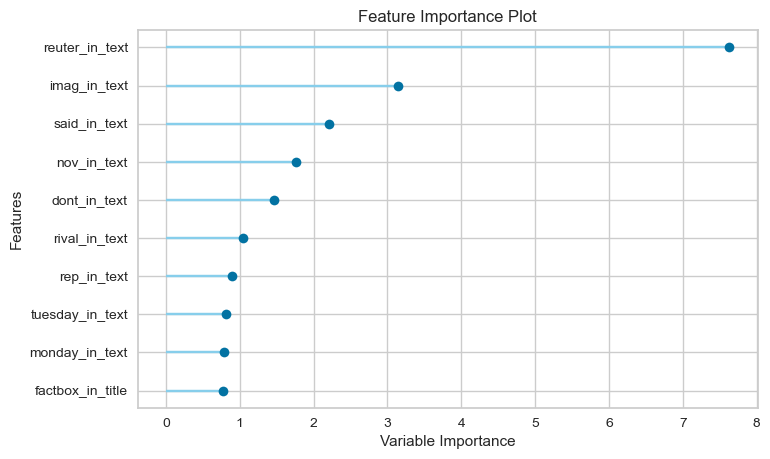

In [53]:
# Lets look at them
plot_model(model_ridge, plot='feature')

In [54]:
# Tuning
tuned_model_ridge = tune_model(model_ridge)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
3,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
4,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
5,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
6,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
9,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


In [55]:
# Finalize the model
final_model = finalize_model(tuned_model_ridge)

In [56]:
# Get list w/o target
val_data = val.drop(['fake'], axis=1)

In [57]:
val_target = val.fake

In [58]:
# Overall accuracy 
# predict validation data
val_predictions = predict_model(final_model, data=val_data)
val_predictions.Label

0        0
1        0
2        0
3        0
4        0
        ..
13956    1
13957    1
13958    1
13959    1
13960    1
Name: Label, Length: 13961, dtype: int32

In [59]:
# Check stats
print(classification_report(val_target, val_predictions.Label))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11716
           1       0.94      0.99      0.96      2245

    accuracy                           0.99     13961
   macro avg       0.97      0.99      0.98     13961
weighted avg       0.99      0.99      0.99     13961



[Text(0, 0.5, 'Real'), Text(0, 1.5, 'Fake')]

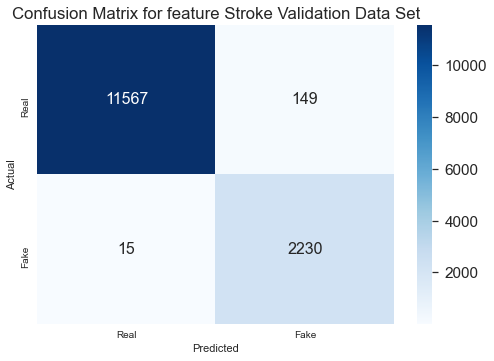

<Figure size 720x504 with 0 Axes>

In [60]:
# Draw confusion matrix 
data = confusion_matrix(val_target, val_predictions.Label)
ax= plt.subplot()

df_cm = pd.DataFrame(data, columns=np.unique(val_target), index = np.unique(val_target))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,ax = ax, annot_kws={"size": 16},fmt='d')# font size
ax.set_title('Confusion Matrix for feature Stroke Validation Data Set') 
ax.xaxis.set_ticklabels(['Real', 'Fake'])   
ax.yaxis.set_ticklabels(['Real', 'Fake'])

In [65]:
val['pred'] = val_predictions.Label

In [88]:
sort_val['date'] = val[['date']].sort_values('date')

In [93]:
sort_val.reset_index(drop=True)

,date
0,2017-09-01
1,2017-09-01
2,2017-09-01
3,2017-09-01
4,2017-09-01
...,...
13956,2018-02-18
13957,2018-02-18
13958,2018-02-19
13959,2018-02-19


In [112]:
unique_dates = pd.to_datetime(pd.unique(sort_val.date))

In [163]:
accuracy_date = []
accuracy_rate = []
for check_date in unique_dates:
    # print(check_date)
    # Ditto
    accuracy_check = val[val['date'] == pd.to_datetime(check_date)]
    accuracy_rate.append(accuracy_score(accuracy_check.fake,accuracy_check.pred))
    accuracy_date.append(pd.to_datetime(check_date))
    

In [186]:
acc_df1 = pd.DataFrame(pd.to_datetime(accuracy_date))

In [187]:
acc_df2 = pd.DataFrame(accuracy_rate)

In [189]:
acc_df = pd.concat([acc_df1,acc_df2],axis=1)

In [190]:
acc_df

,0,0
0,2017-09-01,0.987654
1,2017-09-02,0.983333
2,2017-09-03,0.962963
3,2017-09-04,0.973684
4,2017-09-05,1.000000
...,...,...
123,2018-02-15,1.000000
124,2018-02-16,1.000000
125,2018-02-17,1.000000
126,2018-02-18,1.000000


In [191]:
acc_df.columns = ['Date','Accuracy']

In [192]:
acc_df

,Date,Accuracy
0,2017-09-01,0.987654
1,2017-09-02,0.983333
2,2017-09-03,0.962963
3,2017-09-04,0.973684
4,2017-09-05,1.000000
...,...,...
123,2018-02-15,1.000000
124,2018-02-16,1.000000
125,2018-02-17,1.000000
126,2018-02-18,1.000000


In [194]:
acc_df.to_csv("data\\acc.csv", index=False)